In [ ]:
# Import Libraries

import re
import nltk
import spacy
import pdfplumber
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel, CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from corextopic import corextopic as ct
import numpy as np
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models
%matplotlib inline

nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')

nltk.download('punkt')
nltk.download('stopwords')

nlp = spacy.load('en_core_web_sm')



[nltk_data] Downloading package punkt to /home/sj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Preprocessing 
def read_pdf(file_path):
    with pdfplumber.open(file_path) as pdf:
        full_text = [page.extract_text() for page in pdf.pages]
    return '\n'.join([text for text in full_text if text])

file_path = '../data/future_videos.pdf'
document = read_pdf(file_path)
document = re.sub(r'</?DOCUMENT>', '', document)

import re
sections = re.split(r'\n(?=\d+\.\s|\bImprovements\b|\bAdditional Topics\b)', document)
sections = [s.strip() for s in sections if len(s.strip()) > 50]
print(f"Number of sections: {len(sections)}")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {'would', 'like', 'also', 'could', 'thing', 'video', 'videos', 'future', 'learners', 'business', 'data', 'analytics', 'datum', 'analytic', 'suggest', 'improvements', 'topics', 'additional', 'use', 'make', 'using', 'making', 'show', 'provide'}
    stop_words.update(custom_stopwords)
    tokens = [word for word in tokens if word not in stop_words]
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc if not token.is_punct and len(token.text) > 4]
    return tokens

processed_sections = [preprocess_text(section) for section in sections]
print("First section tokens:", processed_sections[0])
print("Second section tokens:", processed_sections[1])

Number of sections: 76
First section tokens (full): ['realworld', 'study', 'great', 'example', 'business', 'tackle', 'challenge', 'hear', 'actual', 'success', 'story', 'concept', 'relevant']
Second section tokens (full): ['handson', 'tutorial', 'include', 'stepbystep', 'guide', 'demo', 'popular', 'tool', 'see', 'thing', 'action', 'really', 'solidify', 'learn']


In [ ]:
# Vectorization for LDA
dictionary = corpora.Dictionary(processed_sections)
dictionary.filter_extremes(no_below=2, no_above=0.5)  
corpus = [dictionary.doc2bow(section) for section in processed_sections]
print("Dictionary size:", len(dictionary))
print("Corpus size:", len(corpus))

Dictionary size: 432
Corpus size: 76


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=20778) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=20778) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=20778) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=20778) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=20778) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_for

Optimal number of topics: 3, Coherence: 0.43228985465125414


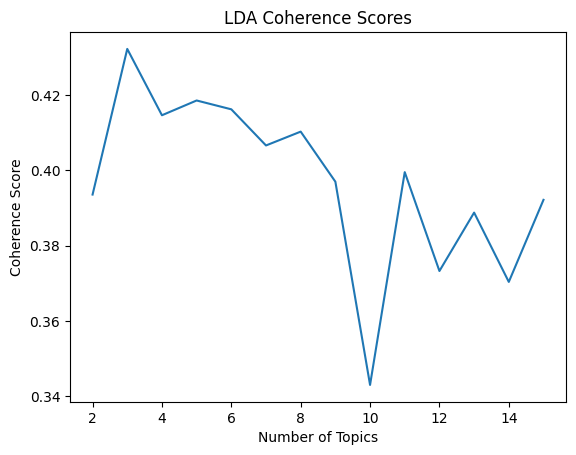

Topic 1: 0.021*"specific" + 0.019*"example" + 0.018*"learn" + 0.015*"study" + 0.014*"skill" + 0.013*"interactive" + 0.012*"concept" + 0.012*"focus" + 0.012*"industry" + 0.012*"tool"
Topic 2: 0.015*"insight" + 0.015*"trend" + 0.015*"skill" + 0.014*"ethical" + 0.014*"study" + 0.014*"privacy" + 0.012*"analysis" + 0.012*"realworld" + 0.012*"discuss" + 0.012*"visualization"
Topic 3: 0.027*"study" + 0.024*"tool" + 0.021*"realworld" + 0.017*"practical" + 0.016*"example" + 0.015*"customer" + 0.015*"predictive" + 0.015*"application" + 0.013*"power" + 0.012*"include"


In [ ]:
#  LDA Topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=30, alpha='auto', eta='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


model_list, coherence_values = compute_coherence_values(dictionary, corpus, processed_sections, limit=16)
optimal_idx = np.argmax(coherence_values)
optimal_model = model_list[optimal_idx]
optimal_num_topics = optimal_idx + 2
print(f"Optimal number of topics: {optimal_num_topics}, Coherence: {coherence_values[optimal_idx]}")


plt.plot(range(2, 16), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("LDA Coherence Scores")
plt.show()

# Print topics
topics = optimal_model.print_topics()
for idx, topic in enumerate(topics):
    print(f"Topic {idx + 1}: {topic[1]}")

In [ ]:
# CorEx Topic Modeling
from corextopic import corextopic as ct
import scipy.sparse as ss

words = list(np.unique([word for section in processed_sections for word in section]))
doc_word = ss.csr_matrix([[section.count(word) for word in words] for section in processed_sections])

# anchors from LDA and document
anchor_words = [
    ['case', 'study', 'realworld', 'tool', 'practical', 'example', 'application', 'demonstration', 'customer'],  
    ['trend', 'predictive', 'machine', 'learning', 'cloud', 'quantum', 'automation', 'deep'],                  
    ['ethical', 'privacy', 'visualization', 'skill', 'insight', 'bias', 'industry', 'practice']
]
anchor_strength = 5

corex_model = ct.Corex(n_hidden=3, seed=42, max_iter=200)
corex_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=anchor_strength)


topics = corex_model.get_topics()
for idx, topic in enumerate(topics):
    topic_words = [word for word, weight, _ in topic[:10]]
    print(f"Topic {idx + 1}: {', '.join(topic_words)}")


tc = corex_model.tc
print(f"CorEx Total Correlation: {tc}")

Topic 1: realworld, demonstration, study, tool, application, practical, example, customer, handson, apply
Topic 2: trend, automation, machine, predictive, learning, field, cloud, company, aipowere, report
Topic 3: practice, insight, skill, visualization, privacy, ethical, industry, responsible, technology, forecast
CorEx Total Correlation: 40.058022179838886


In [ ]:
# Evaluation and Visualization
# LDA Visualization
pyLDAvis.enable_notebook()
vis_data = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary)
pyLDAvis.save_html(vis_data, 'lda_visualization.html')

# CorEx Total Correlation
tc = corex_model.tc
print(f"CorEx Total Correlation: {tc}")

# Recap
print("\nLDA Topics:")
for idx, topic in enumerate(optimal_model.print_topics()):
    print(f"Topic {idx + 1}: {topic[1]}")
print("\nCorEx Topics:")
for idx, topic in enumerate(corex_model.get_topics()):
    print(f"Topic {idx + 1}: {', '.join([word for word, _, _ in topic[:10]])}")

/home/sj/code/iwazolab/future_videos/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=20778) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/sj/code/iwazolab/future_videos/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=20778) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/sj/code/iwazolab/future_videos/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=20778) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/sj/code/iwazolab/future_videos/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=20778) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


CorEx Total Correlation: 40.058022179838886

LDA Topics:
Topic 1: 0.021*"specific" + 0.019*"example" + 0.018*"learn" + 0.015*"study" + 0.014*"skill" + 0.013*"interactive" + 0.012*"concept" + 0.012*"focus" + 0.012*"industry" + 0.012*"tool"
Topic 2: 0.015*"insight" + 0.015*"trend" + 0.015*"skill" + 0.014*"ethical" + 0.014*"study" + 0.014*"privacy" + 0.012*"analysis" + 0.012*"realworld" + 0.012*"discuss" + 0.012*"visualization"
Topic 3: 0.027*"study" + 0.024*"tool" + 0.021*"realworld" + 0.017*"practical" + 0.016*"example" + 0.015*"customer" + 0.015*"predictive" + 0.015*"application" + 0.013*"power" + 0.012*"include"

CorEx Topics:
Topic 1: realworld, demonstration, study, tool, application, practical, example, customer, handson, apply
Topic 2: trend, automation, machine, predictive, learning, field, cloud, company, aipowere, report
Topic 3: practice, insight, skill, visualization, privacy, ethical, industry, responsible, technology, forecast
